# 2.- SMILES string from IR spectra, simple encoder decoder

We are going to build an algortihm that will translate a given IR spectrum to a SMILES sequence. The algorithm is based on the common Encoder Decoder structure. This algorithm is highly based on Ben Trevetts work https://github.com/bentrevett/pytorch-seq2seq "1 - Sequence to Sequence Learning with Neural Networks". The main deviation from the paper he based his algorithm on, is that instead of using a Recurrent Neural Network Encoder, we will use a Convolutional Encoder, mainly because we had promising results in our previous algorithm.

Considering the IR spectrum has never been known to have all the information needed to generate a full molecular structure. The achieved accuracy is actually higher than i expected, especially with such a small dataset

If you have any suggestions, your feedback would be appreciated

The database can be purchased here https://www.nist.gov/srd/nist-standard-reference-database-35. It contains 5308 compound IR spectrums.

SMILES or "Simplified molecular-input line-entry system" is a representation of molecular identity. All molecules identities were converted to this format using rdkit. The use of rdkit for this conversion is not included in this file.

An example: 

![alternative text](./assets/molecule 1 with smiles.jpg)



The algorithms structure is the following:

![alternative text](./assets/Global Arqui.png)

In essence, a spectrum is encrypted in to a vector containing the necessary information readily available for a decoder funciton to decode it.

Each component and its respective mechanism will be shown in detail.


Importing a few libraries

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import time
import math
import random
import re

Setting our device to GPU if available

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Prep

The dataset is unfortunately not mine so i can't post it. It can be purchased in its raw form from 

In [3]:
df=pd.read_pickle('df_2.pkl')

In [4]:
df

,CAS,SMILES,3846,3842,3838,3834,3830,3826,3822,3818,...,586,582,578,574,570,566,562,558,554,550
0,100-02-7,O=[N+]([O-])c1ccc(O)cc1,0.000122,0.000098,0.000091,0.00007,0.000038,0.000055,0.000079,0.000072,...,0.000434,0.000434,0.000449,0.000475,0.000406,0.000307,0.000293,0.000175,0.000146,0.000278
1,100-06-1,COc1ccc(C(C)=O)cc1,0.000147,0.000152,0.000176,0.000132,0.000078,0.000054,0.000054,0.000069,...,0.004322,0.005106,0.005365,0.005356,0.005145,0.004606,0.003925,0.003209,0.002768,0.00124
2,100-10-7,CN(C)c1ccc(C=O)cc1,0.000182,0.000166,0.00014,0.000073,0.000064,0.000048,0.000088,0.000105,...,0.00049,0.000255,0.000073,0.00008,0.000126,0.000182,0.000198,0.000085,0.00016,0.000336
3,100-11-8,O=[N+]([O-])c1ccc(CBr)cc1,0.0002,0.000165,0.000139,0.000131,0.000113,0.000157,0.000183,0.000148,...,0.001296,0.000826,0.000513,0.000313,0.000191,0.000052,0.000035,0.000009,0.000209,0.000391
4,100-14-1,O=[N+]([O-])c1ccc(CCl)cc1,0.00022,0.00017,0.00012,0.00014,0.00014,0.00008,0.0001,0.00012,...,0.00027,0.00019,0.00012,0.00002,0.00016,0.0003,0.00028,0.0002,0.00023,0.00022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,99-96-7,O=C(O)c1ccc(O)cc1,0.003148,0.000441,0.002392,0.002015,0.001133,0.001511,0.003903,0.000252,...,0.127616,0.084993,0.059495,0.065099,0.077627,0.065791,0.054962,0.051751,0.042937,0.03853
3103,99-97-8,Cc1ccc(N(C)C)cc1,0.006146,0.006086,0.007893,0.005905,0.005182,0.005724,0.00482,0.007291,...,0.007713,0.004037,0.00711,0.014039,0.017654,0.011147,0.018558,0.001024,0.015606,0.01904
3104,99-99-0,Cc1ccc([N+](=O)[O-])cc1,0.005459,0.00234,0.004875,0.005654,0.005459,0.004485,0.006044,0.00351,...,0.010724,0.00351,0.006434,0.005849,0.007019,0.00117,0.004485,0.00156,0.005069,0.004485
3106,999-21-3,C=CCOC(=O)/C=C\C(=O)OCC=C,0.001788,0.003088,0.001463,0.0026,0.003251,0.001138,0.003738,0.002926,...,0.031531,0.031043,0.029256,0.020966,0.019016,0.025192,0.026167,0.028768,0.028443,0.023242


Define a function that will take the smiles string as input and output a list of tokens

In [5]:
def tokenize(smiles_string):
    #tokens=re.findall(".",smiles_string)
    tokens=re.findall("\[.+?]|Br|Cl|.",smiles_string)
    return tokens

Remove strings containing more than 20 tokens. Just because GRU's can be limited when having to deal with too many time steps. 
For this, we will create a column that will indicate if a given row contains a smiles string containing more than 20 tokens. Later we delete the rows that do and we delete the column

In [6]:
over_20=[]
for x in range(4836):
    if len(tokenize(df.iloc[x,1]))>20:
        over_20.append(1)
    else:
        over_20.append(0)
        
df.insert(1, 'Over_20', over_20, True)

df=df[df.Over_20!=1]
df=df.drop(columns={'Over_20'})



Save absorbance values to a list

In [7]:
absor=[]
for x in range(len(df)):
    ab_values=[]
    for y in range(2,827):
        ab_values.append(df.iloc[x,y]) #1/(10**(df.iloc[x,y]))
    absor.append(ab_values)

For each smiles string, a '<sos>' token is appended at the beggining, a '<eos>' token at the end, and as many 'padding' tokens as needed to make the length of each tokens list for each compound the same length

In [8]:
unique_tokens=[]
unique_tokens.append('<sos>')
unique_tokens.append('<eos>')
unique_tokens.append('padding') #this is padding

for x in range(len(df)):
    for token in tokenize(df.iloc[x,1]):
        if token not in unique_tokens:
            unique_tokens.append(token)


In [9]:
unique_tokens

['<sos>',
 '<eos>',
 'padding',
 'O',
 '=',
 '[N+]',
 '(',
 '[O-]',
 ')',
 'c',
 '1',
 'C',
 'N',
 'Br',
 'Cl',
 '#',
 'n',
 '2',
 '3',
 '/',
 'S',
 '-',
 '\\',
 '[C@@H]',
 '[nH]',
 'o',
 'P',
 '[C@H]',
 'I',
 '.',
 'F',
 's',
 '[O]',
 '[Si]',
 '[n+]',
 '[N-]',
 '[Sn]',
 '[Hg]',
 '[se]',
 'B',
 '[C]',
 '[PH]',
 '[SiH2]',
 '[GeH4]',
 '[2H]']

In [10]:
len(unique_tokens)

45

Now each molecules smiles string will be converted to a one-hot-encoded representation.

In [11]:
#We first generate len(unique_tokens) one-hot-encoddings
 
one_hotted_tokens=F.one_hot(torch.arange(0,len(unique_tokens)), num_classes=len(unique_tokens))

#Then convert each token for each sentence in to one hot encoded and also append <sos>, <eos> and padding accordingly
smiles=[]
for x in range(len(df)):
    scrap=[]
    scrap.append(one_hotted_tokens[0].numpy()) #first append start of sentence
    
    
    for token in tokenize(df.iloc[x,1]):
        
        scrap.append(one_hotted_tokens[unique_tokens.index(token)].numpy())#token
    scrap.append(one_hotted_tokens[1].numpy())#<eos>
        
    while len(scrap)<=21:
        scrap.append(one_hotted_tokens[2].numpy())#padding
                     
    smiles.append(scrap)

So for example:

In [12]:
print('this smiles string ', df.iloc[0,1], '\nwas converted to: ', smiles[0] )

this smiles string  O=[N+]([O-])c1ccc(O)cc1 
was converted to:  [array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64), array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64), array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64), array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64), array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

Notice how the first array has a 1 and then only zeros. This array represents the '<sos>' token

Print the length of all one-hot-encoded smiles strings: (will be the same for all)

In [13]:
print(len(smiles[0]))
print(len(smiles[1]))

22
22


Define a dataset class

In [14]:
class dataset(Dataset):
    def __init__(self, smiles, absorbances):
        self.x=torch.tensor(absorbances).view(-1,1,825)
        self.y=torch.tensor(smiles).float() #FloatTensor
        self.len=len(absorbances)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

Instance an object of class dataset

In [15]:
data=dataset(smiles, absor)

Split the data into training set, validation set and test set. 

In [16]:
train_set, val_set, test_set= torch.utils.data.random_split(data, [3200, 460, 33], generator=torch.Generator().manual_seed(42))

Visualize source and target on the train_set, for a batch size of 60 

In [17]:
train_loader=DataLoader(dataset=train_set, batch_size=60)
val_loader=DataLoader(dataset=val_set, batch_size=30)

#print an example

print('absorbance', list(train_loader)[0][0])
print('absorbance shape', list(train_loader)[0][0].shape)
print('squeezed', list(train_loader)[0][0].squeeze(1).shape)
print('smiles', list(train_loader)[0][1])

print('smiles shape', list(train_loader)[0][1].shape)

absorbance tensor([[[8.7119e-03, 6.9695e-03, 6.9695e-03,  ..., 1.5546e-01,
          1.4326e-01, 1.5604e-01]],

        [[2.4960e-04, 2.0410e-04, 2.1450e-04,  ..., 1.5600e-04,
          2.1450e-04, 2.3270e-04]],

        [[8.1900e-05, 8.1900e-05, 6.6300e-05,  ..., 8.1900e-05,
          4.2900e-05, 1.0140e-04]],

        ...,

        [[3.2700e-04, 1.9620e-04, 2.8340e-04,  ..., 1.3080e-04,
          1.0900e-04, 6.5400e-05]],

        [[2.0954e-02, 2.1662e-02, 2.4777e-02,  ..., 8.0702e-03,
          8.2118e-03, 9.4861e-03]],

        [[1.9140e-04, 2.7060e-04, 2.9370e-04,  ..., 3.1350e-04,
          2.0790e-04, 9.5700e-05]]])
absorbance shape torch.Size([60, 1, 825])
squeezed torch.Size([60, 825])
smiles tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ...,

# Neural System

## Encoder


![alternative text](./assets/Arqui 1.png)
![alternative text](./assets/Arqui 2.png)

The Encoders goal is to translate the spectrum in to a list of numbers (the code). The code will later on be "decoded" by the decoder into a SMILES sequence.

This encoder is very basic, and it uses a whole lot of dropout. 

Given a list of values containing the absorbances of a given compound for a range of wavelengths, the algo will first perform a 1D convolution operation. 

#### 1st Convolution: 

With a specified stride(jump) the Kernels are sweeped through the spectrum to generate n Activation maps, where n is also the number of output channels and the number of kernels. 

#### 1st Max pooling:

The poolings kernel is sweeped though the Activation maps selecting the max value of each set of number from each map per stride.

#### 2nd Convolution:

Now the convlution has more than one input channel, so the operation is a little more complicated. m output channels will be generated. For each output channel (each activation map), there are n kernels. For the first activation map, n different kernels are swept though each pooled vector, generating one braket of operations in the diagram. For the next activation map, a different set of n kernerls are swet though and so forth. Fundamentally there is one kernel per pooled vector per output map, so n*m kernels.

#### 2nd Max pooling:

A Max pooled vector is generated from each activation map, same as in 1st Max pooling.

#### Concatenation:

M pooled vectors are concatenated

#### 1st Linear:

For the first hidden value Each value of the concatenated Pooled vector is multiplied by a weight, added together and a bias is added as well. Subsequently the resulting value goes through an activation function (ReLU). For the next hidden values a new set of weights and bias is applied, and all passed through ReLU as well. 

#### 2nd Linear:

For the first Code vector value, Each hidden value is multiplied by a weight, added together and a bias is added as well. Subsequently the resulting value goes through an activation function (ReLU). For the next hidden values a new set of weights and bias is applied and all passed though ReLU. Code is just a list of numbers.



In [18]:
class Encoder(nn.Module):
    def __init__(self, out_1, out_2, conv_out_size, out_3, p, code_dim):
        super(Encoder,self).__init__()
        self.cnn1=nn.Conv1d(in_channels=1, out_channels=out_1, kernel_size=4, stride=1, padding=0)
        self.maxpool1=nn.MaxPool1d(kernel_size=3, stride=2)
        
        self.cnn2=nn.Conv1d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=0)
        self.maxpool2=nn.MaxPool1d(kernel_size=3, stride=2)
        
        self.dropout=nn.Dropout(p)
        self.linear=nn.Linear(conv_out_size*out_2, out_3) 
        self.dropout2=nn.Dropout(p=0.5)
        self.linear2=nn.Linear(out_3, code_dim)
        self.dropout3=nn.Dropout(p=0.5)
        

    def forward(self, x):
        
        #1st conv and 1st pooling
        
        x=self.cnn1(x)
        x=torch.relu(x)
        x=self.maxpool1(x)
        
        #2nd conv and 2nd pooling
        
        x=self.cnn2(x)
        x=torch.relu(x)
        x=self.maxpool2(x)
        
        #Concatting
        
        x=x.view(x.size(0), -1)
        x=self.dropout(x)
        
        #first linear
        
        x=self.linear(x)
        x=torch.relu(x)
        x=self.dropout2(x)
        
        #2nd Linear
        
        x=self.linear2(x) 
        x=torch.relu(x)
        x=self.dropout3(x)
        
        
        return x

Define a function that will comput the output size of convolutional or pooling layers

In [19]:
def conv_output_size(Lin, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    size = floor( ((Lin + (2 * pad) - ( dilation * (kernel_size - 1) ) - 1 )/ stride) + 1)
    return size

In [20]:

o1=conv_output_size(825, kernel_size=4, stride=1)
o2=conv_output_size(o1, kernel_size=3, stride=2)

o3=conv_output_size(o2, kernel_size=3, stride=1)
o4=conv_output_size(o3, kernel_size=3, stride=2)

Just to visualize the output Create an instance of class encoder and input the first batch

In [21]:
encoder=Encoder(out_1=8, out_2=8, conv_out_size=o4, out_3=1000, p=0.5, code_dim=400)

print('code: ', encoder(list(train_loader)[0][0]))
print('\n')
print('code shape: ', encoder(list(train_loader)[0][0]).shape)

code:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0037, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0293],
        ...,
        [0.0000, 0.0000, 0.0217,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1540],
        [0.0000, 0.0000, 0.0000,  ..., 0.2375, 0.0350, 0.1375]],
       grad_fn=<MulBackward0>)


code shape:  torch.Size([60, 400])


C:\Users\ferna\anaconda3\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Decoder

![alternative text](./assets/Arqui 3.png)

The decoder is nothing but a recurrent unit with one time step, meaning we will always input a sequence length of 1.

The decoder used in the code is a GRU, the one represented by the graph resembles a standard RNN, i didn't add the equations for a GRU because they are somewhat extensive, but in essence a recurrent unit takes a previous hidden and combines it with the current time step input to generate a new hidden state, and so forth. 

So following the sequence:

#### Embedding lookup

The input is the previous token (this is a vector of len (one-hot-encodding)). Argmax retrieves the index of the highest number of said vector. This index (single number), is the input to the embedding lookup function. The embedding lookup function will locate the embedding vector for this index.  

#### Recurrent Unit

The reason why we use a one time step recurrent unit, is because the input in each timestep is the previous timestep output, so not only the previous hidden, but the actual output as well. It is not possible to let the GRU create timestep outputs without timestep inputs. 

So with the embedding and previous hidden, new hidden is computed. New hidden is passed through 2 hidden layers with ReLU activations, and the prediction vector is generated. 

Saying previous hidden may be confusing, in the spectra2sequence diagram and code the mechanisms will seem more clear. 


In [22]:
class Decoder(nn.Module):
    def __init__(self, size_of_vocab, embedding_dim, code_dim):
        super(Decoder, self).__init__()
    
        self.embedding=nn.Embedding(size_of_vocab, embedding_dim)
        self.gru=nn.GRU(input_size=embedding_dim, hidden_size=code_dim, batch_first=True)
        self.linear=nn.Linear(code_dim, 150) #code_dim is same size as hidden dim
        self.linear2=nn.Linear(150, size_of_vocab)
        self.dropout=nn.Dropout(p=0.5)
        
        
        
    def forward(self, input, hidden):
        
        input=input.argmax(1)

        #Size([batch_size])

        embedded=self.dropout(self.embedding(input)) #(batch_size, Embedding_dim)

        #Size([batch_size, emb_dim])
        
        embedded=embedded.unsqueeze(0).permute(1,0,2) #(batch_size, seq_len, embedding_dim)

        #Size([batch_size, 1, emb_dim])

        output, h_n=self.gru(embedded, hidden) 

        #Size([1, bathc_size, code])
        
        prediction=self.dropout(torch.relu(self.linear(h_n)))

        #Size([1, batch_size, 150])
        
        prediction=self.linear2(prediction) 

        #Size([1, batch_size, len(unique_tokens)])
        

        
        return prediction, h_n

Visualize the output for first time step (assuming a code dimension of 400)

In [23]:
decoder=Decoder(size_of_vocab=len(unique_tokens), embedding_dim=10, code_dim=400)

In [24]:
#Time step 1

hid=encoder(list(train_loader)[0][0]).unsqueeze(0)
print('code', hid)
print('code shape', hid.shape)

inputs=list(train_loader)[0][1][:,0]
print('input', inputs)
print('input shape', inputs.shape)

decoder(list(train_loader)[0][1][:,0], hid) #input is embedding(unique_tokens.index(<sos>))

print('\n')

code tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0058, 0.2350, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0540, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0246],
         [0.3379, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2101, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       grad_fn=<UnsqueezeBackward0>)
code shape torch.Size([1, 60, 400])
input tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
input shape torch.Size([60, 45])




## Spectrum 2 Sequence

![alternative text](./assets/Arqui 4.png)
![alternative text](./assets/Arqui 5.png)



The diagram only shows what happens after the code is generated by the encoder. 

Once the code is generated this will be the first recurrent hidden vector, and the first input will be the one hot encodding of the start of sentence token <sos>. A new hidden is generated and after 2 linear layers a prediction is generated. The new prediction and new hidden are used to calculate the following prediction, and so forth. 
    
Teacher forcing is when instead of inserting the previous prediction, the ground truth previous predictions one hot encodding is inserted. Teacher_forcing_ratio is the probability that the ground truth token will be inserted.
    
In Trevetts implementation, the GRUs are trained with different output sequence lengths since he used the bucket iterator. We havent used this so we will always generate the same amount of tokens. 

In [25]:
class spectrum2seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(spectrum2seq, self).__init__()
        
        self.encoder=encoder
        self.decoder=decoder
        self.device=device
        
        
    def forward(self, absorbances, smiles, teacher_forcing_ratio=0.5):
        
        
        hidden=self.encoder(absorbances).unsqueeze(0) #first hidden is code
        
        vector=smiles.shape[2] #This is the dimension of a single prediction vector (=one-hot-encoding dim)
        batch_size=smiles.shape[0] #batch size
        output_len=smiles.shape[1] #how many predictions it will output (basically seq len)
        predictions = torch.zeros(output_len, batch_size, vector).to(self.device) #empty tensor to store predictions
        
        input=smiles[:,0] #first token is <sos>
     
        for t in range(1, output_len): #Always generate output_len tokens,this will be 22 with this implementation
            
            prediction, hidden=self.decoder(input, hidden)
            #prediction Size([1, 60, 45])
            #hidden Size([1, 60, 400]
            
            predictions[t]=prediction
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            
            if t!=output_len-1:
            
                input=smiles[:,t+1] if teacher_force else prediction.squeeze(0)
                
            else:
                input=prediction.squeeze(0)

        return predictions.permute(1,0,2) #this still has to be passed through an argmax to get the tokens.
            

## Training the model

Define a function to keep track of the total training time

In [26]:
def Training_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Set up random seeds to always obtain the same result

In [27]:
SEED = 4320

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Instance encoder, decoder and spectrum2sequence

In [28]:

o1=conv_output_size(825, kernel_size=4, stride=1)
o2=conv_output_size(o1, kernel_size=3, stride=2)

o3=conv_output_size(o2, kernel_size=3, stride=1)
o4=conv_output_size(o3, kernel_size=3, stride=2)

In [29]:
encoder=Encoder(out_1=20, out_2=20, conv_out_size=o4, out_3=2000, p=0.5, code_dim=400)
decoder=Decoder(size_of_vocab=len(unique_tokens), embedding_dim=100, code_dim=400)
s2s=spectrum2seq(encoder, decoder, device=device).to(device)

Define loss function and optimizer

In [30]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adagrad(s2s.parameters(), lr=0.001) #lr=0.01

In [31]:
def train_model(epochs, model, optimizer, train_loader, val_loader):
    
    global train_loss
    global val_loss
    
    train_loss=[]
    val_loss=[]

    start_time=time.time()

    for epoch in range(epochs):
        for x, y in train_loader:
            model.train()
            x,y=x.to(device), y.to(device) #Send tensors to GPU
            optimizer.zero_grad() #Clear Gradients in optimizer
            yhat=model(x, smiles=y) #Make prediction
            loss=criterion(yhat.permute(0,2,1), y.argmax(2)) #changing to batch_size, num_classes, d1
            loss.backward() #Compute gradient of loss vs all learnable parameters
            optimizer.step() #Update parameters parameter2=parameter1-Learning_Rate(dL/dparameter)
        
        train_loss.append(loss.data.cpu())
          
        for x_val, y_val in val_loader:
            model.eval()
            x_val, y_val=x_val.to(device), y_val.to(device)
            z=model(x_val, y_val, teacher_forcing_ratio=0)
            loss_v=criterion(z.permute(0,2,1), y_val.argmax(2))
        
        
        val_loss.append(loss_v.data.cpu())
        
            
    end_time=time.time()
    
    train_mins, train_secs = Training_time(start_time, end_time)
    
    
    print('Time: ', train_mins, ':', train_secs)
    
        

In [32]:
train_model(epochs=1500, model=s2s, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader)

Time:  38 : 35


Plotting Loss

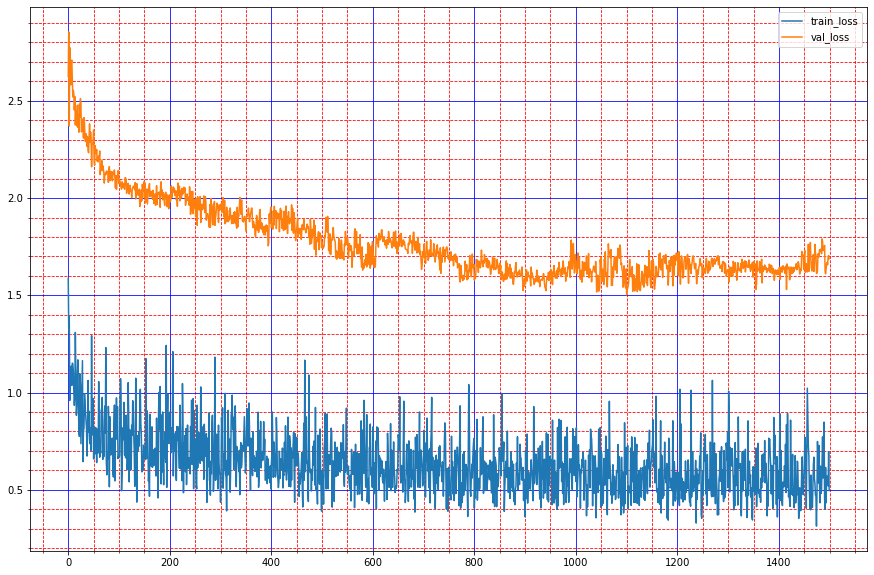

In [37]:

plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.rcParams["figure.figsize"] = (15,10)
plt.minorticks_on()
plt.grid(b=True, which='major', color='b', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.legend()
plt.show()

## Visualizing some predictions

Visualize predictions using the validation set. The follwing code block will show the prediction and true smiles string for the first 3 molecules of batch. Padding tokens will not be shown

In [43]:
accuracy=0
correct=0
incorrect=0

totally_correct=0
not_totally_correct=0

for x, y in val_loader:
    x,y= x.to(device), y.to(device)
    
    prediction=s2s(x,y).argmax(2)
    truth=y.argmax(2)
    
    for n in range(3):
    
        pred=''
        for value in prediction[n]:
            if value != 2: #if not padding token
                pred=pred+unique_tokens[value]
            
        tru=''
        for value in truth[n]:
            if value !=2: #if not padding token
                tru=tru+unique_tokens[value]
                
        print('prediction', pred)
        print('truth:', tru)
            
    for m in range(len(prediction)):
        for index in range(len(prediction[m])):
            if prediction[m][index]!=2 and prediction[m][index]!=0:
                if prediction[m][index]==truth[m][index]: #if token is same
                    correct+=1
                else:
                    incorrect+=1
                    
    for m in range(len(prediction)):
        
        if (prediction[m]==truth[m]).sum()==len(prediction[m]): #in token is same
            totally_correct+=1

        else:
            not_totally_correct+=1
                    
    
    print('\n')
    
accuracy=correct/(incorrect+correct)
print('Accuracy: ', accuracy)
print('Totally correct predictions', totally_correct)
print('total amount of predictions', totally_correct+not_totally_correct)

prediction <sos>CCCCCCCCC1<eos>
truth: <sos>BrC1CCCCCC1<eos>
prediction <sos>CCCCCCC1CCCCCCCCCC
truth: <sos>CC(CO)C1CCCCC1<eos>
prediction <sos>CCCCCCCCC(C)CCCC
truth: <sos>CC(C)CCCC(C)O<eos>


prediction <sos>CCCCccc(F)ccc1<eos><eos>
truth: <sos>CCc1ccc(F)cc1<eos>
prediction <sos>NCCCCCC
truth: <sos>NCCCO<eos>
prediction <sos>CCCCCccN)cCcccccc
truth: <sos>CCCCCC(N)CCCCC<eos>


prediction <sos>Cc1cccc(ccc1<eos><eos>
truth: <sos>Cc1c(N)cccc1Cl<eos>
prediction <sos>Cc1cccc)nccccccc1<eos>
truth: <sos>Cc1cc(Cl)nc2ccccc12<eos>
prediction <sos>Oc1ccccOc2cccccc)c11<eos>
truth: <sos>Oc1ccc(Oc2ccccc2)cc1<eos>


prediction <sos>CC(=O)Cl)Oc1ccccc1<eos>
truth: <sos>O=C(CCCl)Oc1ccccc1<eos>
prediction <sos>CCNC=O<eos>
truth: <sos>CCNC=O<eos>
prediction <sos>COC(=O)CCCCCCCO<eos><eos>
truth: <sos>COC(=O)CCCCC(=O)OC<eos>


prediction <sos>CCCCC(C)C(=O)O<eos>
truth: <sos>CC(C)(C)C(=O)O<eos>
prediction <sos>CCCCcc1ccccc1<eos>
truth: <sos>OCCNCc1ccccc1<eos>
prediction <sos>Cc1ccc(C)2cccccc)c11<eos>
truth:

Accuracy on validation set is 0.7896, not bad. And impresively 56 out of 460 predictions were 100% correct. Would be very interesting to try using a larger dataset

Its possible to notice that some smiles rules are broken, would be interesting to find out the reason why the algorithm is not being deterministic with these cases

Ideally there should be an <eos> at the end of all predictions, notice how some do and some dont. Meaning that the algorithm sometimes isnt sure if it outputted all tokens.

Visualize prediction with the test_set

In [35]:
test_loader=DataLoader(dataset=test_set, batch_size=1)

In [39]:
accuracy=0
correct=0
incorrect=0

for x, y in test_loader:
    x,y= x.to(device), y.to(device)
    
    prediction=s2s(x,y).argmax(2)
    truth=y.argmax(2)
    
    pred=''
    for value in prediction[0]:
        if value != 2: #if not padding token
            pred=pred+unique_tokens[value]
            
    tru=''
    for value in truth[0]:
        if value !=2: #if not padding token
            tru=tru+unique_tokens[value]
                
    print('prediction', pred)
    print('truth:', tru)
            
    for m in range(len(prediction)):
        for index in range(len(prediction[m])):
            if prediction[m][index]!=2 and prediction[m][index]!=0:
                if prediction[m][index]==truth[m][index]: #if token is same
                    correct+=1
                else:
                    incorrect+=1
                    
    
    print('\n')
    
accuracy=correct/(incorrect+correct)
print(accuracy)

prediction <sos>CCCCCCC)CC(C)(C)C<eos><eos>
truth: <sos>CC1=C(C)CC(C)(C)C1<eos>


prediction <sos>CCC(C)=O<eos>
truth: <sos>CNC(C)=O<eos>


prediction <sos>CC(((((=(O)CCOCC<eos>
truth: <sos>C=CP(=O)(OCC)OCC<eos>


prediction <sos>C1CC[C@@H]2CCC[C@H]2C1<eos>
truth: <sos>C1CC[C@@H]2CCC[C@H]2C1<eos>


prediction <sos>ClC(Cl)((ClCl)Br<eos>
truth: <sos>BrC(Br)=C(Br)Br<eos>


prediction <sos>FCC=C<eos>
truth: <sos>O=C=O<eos>


prediction <sos>CCCCCCCCCC)CCCC<eos>
truth: <sos>CCCCN(CCCC)CCCC<eos>


prediction <sos>CCCCCCCCcc1<eos>
truth: <sos>CCCCc1ccco1<eos>


prediction <sos>CCcccccccccc<eos>
truth: <sos>CCOc1ccccc1O<eos>


prediction <sos>CCCCCC)CCC(C)CCC
truth: <sos>CCC(=O)CCC(C)C<eos>


prediction <sos>C=C(O))ccccc1C=O<eos>
truth: <sos>C=CCOc1ccccc1C=O<eos>


prediction <sos>CC=CCc2cccccc1<eos><eos>
truth: <sos>C1=C(c2ccccc2)CCC1<eos>


prediction <sos>CCCCCCCCN<eos>
truth: <sos>CCC1CCCCN1<eos>


prediction <sos>CCCccccccc1<eos>
truth: <sos>CCCc1ccccc1<eos>


prediction <sos>Cc1cncccC)c1

A small amount of samples were used on the test set, a possibility for the validation-test set accuracy gap